Stock Calculator Automation
----------------
This automation allows you to create a simple webpage with an input form that allows to select a date and when submitted, you see a higest rising stock from a selected set of stocks. 


Needed imports

In [ ]:
from bspump.jupyter import *
from bspump.http.web.server import *
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib
import time
import io
from datetime import date, timedelta
import base64

Now we can declare a mock event, allowing us to execute all cells during development without needing to deploy the code to see the results.

In [ ]:
event = {
    "form": {
        "date": "2025-06-05"
    }
}


Defining an autopipline, the core of the automation. We define its source and sink.

In [ ]:
today = datetime.now()

auto_pipeline(
    source=lambda app, pipeline: WebFormSource(
        app, pipeline,
        route="/",
        form_intro="""
            <h1>Select a date and click submit to see a visualization</h1>
        """,
        fields=[
            DateField(
                "date",
                display="Date",
                default=today.strftime("%Y-%m-%d")
            ),
        ]
    ),
    sink=lambda app, pipeline: WebSink(app, pipeline),
    name="WebServerPipeline"
)


Pipeline section
----------------

Everything after this is rerun every time an event comes in. At run time, the `event` variable is automatically set with the value of the event that comes from the source.

We can do whatever transformations we please, and then, by setting `event` at the end of the notebook, the value of `event` will automatically be sent to the sink.

### Helper Functions
Convert the single date string into a datetime and the before/after window

In [ ]:
# Grab the ISO date string from the form
parsed_date_str = event["form"]["date"]
# e.g. "2025-06-05" → datetime(2025,6,5)
parsed_date = datetime.fromisoformat(parsed_date_str)

day_before = parsed_date - timedelta(days=1)
day_after  = parsed_date + timedelta(days=1)



Here is a helper function of the output layout.

In [ ]:
def output_layout(parsed_date,top_stock_name,top_stock_change,img_data) -> str:
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Stock Performance</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                text-align: center;
                background-color: #f5f5f5;
                padding: 40px;
            }}
            h1 {{
                color: #333;
                margin-bottom: 20px;
            }}
            img {{
                border: 1px solid #ccc;
                max-width: 90%;
                height: auto;
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }}
            button {{
                background-color: #0275d8;
                color: white;
                border: none;
                padding: 10px 20px;
                font-size: 16px;
                border-radius: 5px;
                cursor: pointer;
            }}
            button:hover {{
                background-color: #025aa5;
            }}
        </style>
    </head>
    <body>
        <h1>📈 Top Stock on {parsed_date}: {top_stock_name} (change {top_stock_change:.2f}%)</h1>
        <img src="data:image/jpeg;base64,{base64.b64encode(img_data.getvalue()).decode()}" alt="Stock Performance">
        <button onclick="window.history.back()">🔙 Go Back</button>
    </body>
    </html>
    """
    return html


def output_no_data_found() -> str:
    html = """
    <!DOCTYPE html>
    <html>
    <head>
       <title>No Data Found</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                text-align: center;
                background-color: #f5f5f5;
                padding: 40px;
            }
            h1 {
                color: #d9534f;
                margin-bottom: 20px;
            }
            p {
                color: #555;
                font-size: 18px;
                margin-bottom: 30px;
            }
            button {
                background-color: #0275d8;
                color: white;
                border: none;
                padding: 10px 20px;
                font-size: 16px;
                border-radius: 5px;
                cursor: pointer;
            }
            button:hover {
                background-color: #025aa5;
            }
        </style>
    </head>
    <body>
        <h1>⚠️ No Stock Data Found</h1>
        <p>Markets might be closed, try a different date.</p>
        <button onclick="window.history.back()">🔙 Go Back</button>
    </body>
    </html>
    """
    return html

First, we declare global variables and handle the input from the WebFormSource.

In [ ]:
# Global variables
STOCKS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "JPM", "NFLX", "AMD"]

HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }

# Input processing 
form = event["form"]

# event["form"]["date"] is an ISO string "YYYY-MM-DD"
parsed_date_str = form["date"]

# Convert it into a Python datetime
parsed_date = datetime.fromisoformat(parsed_date_str)

# Compute the window
day_before = parsed_date - timedelta(days=1)
day_after  = parsed_date + timedelta(days=1)

Here, we fetch data from Yahoo Finance and parse it for plotting.

In [ ]:
# Initialize change tracking 
changes = {}

# Iterate over each ticker and fetch data 
for ticker in STOCKS:
    # Convert datetime to UNIX timestamps
    start_ts = int(time.mktime(day_before.timetuple()))
    end_ts = int(time.mktime(day_after.timetuple()))

    # Prepare API request
    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}"
    params = {
        "period1": start_ts,
        "period2": end_ts,
        "interval": "1d"
    }

    try:
        response = requests.get(url, params=params, headers=HEADERS)
        data = response.json()

        result = data["chart"]["result"][0]
        timestamps = result["timestamp"]
        closes = result["indicators"]["quote"][0]["close"]

        # Convert timestamps to readable dates
        dates = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]
        series = pd.Series(closes, index=dates)

        # Compute percent change if both dates exist in the series
        if parsed_date_str in series and day_before.strftime("%Y-%m-%d") in series:
            previous_close = series[day_before.strftime("%Y-%m-%d")]
            current_close = series[parsed_date_str]
            if previous_close and current_close:
                percent_change = ((current_close - previous_close) / previous_close) * 100
                changes[ticker] = percent_change

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

Here, We create a plot from the data.

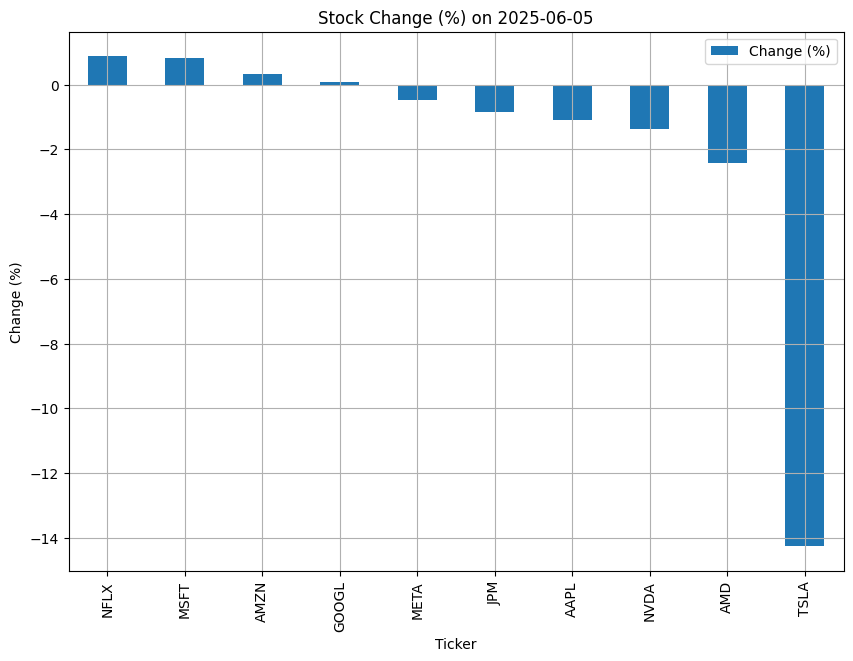

In [ ]:
# install matplotlib if you experience error with the plot while executing the cells in during dev
# %pip install matplotlib

# Prepare output if data is available 
if changes:
    df = pd.DataFrame(list(changes.items()), columns=["Ticker", "Change (%)"])
    df.sort_values("Change (%)", ascending=False, inplace=True)

    # Plotting
    ax = df.plot.bar(
        x="Ticker",
        y="Change (%)",
        title=f"Stock Change (%) on {parsed_date_str}",
        xlabel="Ticker",
        ylabel="Change (%)",
        grid=True,
        figsize=(10, 7)
    )

    # Save plot to buffer
    buf = io.BytesIO()
    ax.figure.savefig(buf, format="jpeg")
    img_data = buf

Here, we handle the output for all possible cases to ensure the WebSink always has something to display to the user.

In [ ]:
if changes:
    # Get top stock info
    top_stock = max(changes, key=changes.get)
    top_stock_name = top_stock
    top_stock_change = changes[top_stock]

    # Build and set response
    response = output_layout(
        parsed_date=parsed_date_str,
        top_stock_name=top_stock_name,
        top_stock_change=top_stock_change,
        img_data=img_data
    )

    event["response"] = response
    event["content_type"] = "text/html"

else:
    event["response"] = output_no_data_found()
    event["content_type"] = "text/html"

Note that the event object still exists in the last cell, so it can be automatically passed as input to the WebSink.